In [1]:
import os
import sys
import json
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import ipywidgets as widgets

from joblib import dump, load

from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import make_pipeline as make_pipeline_imb

from sklearn.base import clone
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, average_precision_score, classification_report,
                             confusion_matrix, make_scorer, precision_recall_curve, roc_auc_score)
from sklearn.model_selection import (StratifiedKFold, cross_val_predict, cross_val_score, 
                                     train_test_split)
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

In [2]:
# Set Seed for all packages
def set_seed(seed=42):
    """Set seeds to make the experiment more reproducible."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

# Load Data

In [3]:
# Define the percentage to load
percentage = '25%'  # Change this to '5%', '10%', etc., as needed

# Base directory for the data subsets
base_dir = f'./data/subsets/{percentage}_subsets/'

# Load Labels
labels = pd.read_csv(f'{base_dir}labels.csv')
stay_ids = labels['stay_id'].unique()

# Load static features
icd_features = pd.read_pickle(f'{base_dir}icd_code_features.pkl')

# Load summarized dynamic features
sum_dynamic_features = pd.read_pickle(f'{base_dir}sum_dynamic_features.pkl')

# Load demographic features
demographic_features = pd.read_pickle(f'{base_dir}demographic_features.pkl')

# Print information to confirm the files are loaded
print(f"Files for {percentage} subset loaded successfully.")
print(f"Number of stays: {len(stay_ids)}")
print(f"ICD Features shape: {icd_features.shape}")
print(f"Summarized Dynamic Features shape: {sum_dynamic_features.shape}")
print(f"Demographic Features shape: {demographic_features.shape}")

Files for 25% subset loaded successfully.
Number of stays: 11895
ICD Features shape: (11895, 1458)
Summarized Dynamic Features shape: (11895, 16)
Demographic Features shape: (11895, 4)


In [4]:
all_static_features = pd.concat([demographic_features, icd_features], axis=1)

In [5]:
sum_dynamic_and_static_features = pd.concat([sum_dynamic_features, all_static_features], axis=1)

# Define Setup for the Models

In [7]:
# Dictionary of DataFrames for selection
dataframes = {
    'Demographic': demographic_features,
    'ICD Codes': icd_features,
    'Summarized Dynamic': sum_dynamic_features,
    'Summarized Dynamic and all Static Features': sum_dynamic_and_static_features,
}

# Create a Dropdown widget for DataFrame selection
df_selector = widgets.Dropdown(
    options=list(dataframes.keys()),
    value='ICD Codes',
    description='Select DataFrame:',
    style={'description_width': 'initial'}
)

# Function to update the DataFrame based on selection
def update_dataframe(change):
    global X  # Define X as a global variable to use it outside this function
    X = dataframes[change.new]  # Update X based on the selection
    print("DataFrame selected:", change.new)  # Optional: Print the selected DataFrame name

# Link the widget to the function
df_selector.observe(update_dataframe, names='value')

# Initialize `X` with the default selection
X = dataframes[df_selector.value]

# Display the widget
display(df_selector)

Dropdown(description='Select DataFrame:', index=1, options=('Demographic', 'ICD Codes', 'Summarized Dynamic', …

Define Columns based on Selected Feature Data Frame

Preprocessing and Cross-Validation Components

In [8]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, labels["label"], stratify=labels["label"], test_size=0.3, random_state=42)

# Define categorical columns based on selection of Features
if df_selector.value in ['Demographic', 'Summarized Dynamic and all Static Features']:
    categorical_cols = ["ethnicity", "insurance", "gender"]
else:
    categorical_cols = []

numerical_cols = [col for col in X.columns if col not in categorical_cols]

# Define your preprocessor with dynamically set columns
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols),
        ('num', StandardScaler(), numerical_cols)
    ])

# Set up the cross-validation framework
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Scoring metrics
scoring = ['accuracy', 'precision', 'recall', 'f1']

Define Function to Create Pipelines

In [9]:
def create_model_pipeline(classifier, use_oversampling=False):
    if use_oversampling:
        pipeline = make_pipeline_imb(preprocessor, RandomOverSampler(random_state=42), classifier)
    else:
        pipeline = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('classifier', classifier)
        ])
    # Set an attribute to mark the use of oversampling
    pipeline.use_oversampling = use_oversampling
    return pipeline

Define Function to Evaluate Models

In [10]:
def generate_model_name(model):
    base_model = model.steps[-1][1] if hasattr(model, 'steps') else model.__class__.__name__
    oversampling_status = "with_oversampling" if hasattr(model, 'use_oversampling') and model.use_oversampling else "without_oversampling"
    
    name = f"{base_model.__class__.__name__}_{oversampling_status}"
    return name

In [11]:
def evaluate_model(model, X, y, scoring, beta=2, cv=5, save_path=None):
    model_name = generate_model_name(model)
    
    # Perform cross-validation scoring
    cv_results = {score: cross_val_score(model, X, y, cv=cv, scoring=score).mean() for score in scoring}
    y_probs = cross_val_predict(model, X, y, cv=cv, method='predict_proba')[:, 1]
    auc_roc_cv = roc_auc_score(y, y_probs)
    auprc_cv = average_precision_score(y, y_probs)

    # Calculate the optimal threshold using F-beta score
    precision, recall, thresholds = precision_recall_curve(y, y_probs)
    f_beta_scores = (1 + beta**2) * (precision * recall) / ((beta**2 * precision) + recall)
    optimal_idx = np.argmax(f_beta_scores)
    optimal_threshold = thresholds[optimal_idx]

    # Cross-validated predictions using the optimal threshold
    y_pred = (y_probs > optimal_threshold).astype(int)

    # Print the cross-validated results
    print(f"Cross-validated Results for {model_name}:")
    print(f"Optimal Threshold: {optimal_threshold:.2f}")
    print(f"Accuracy: {cv_results['accuracy']:.2f}")
    print(f"Precision: {cv_results['precision']:.2f}")
    print(f"Recall: {cv_results['recall']:.2f}")
    print(f"F1-score: {cv_results['f1']:.2f}")
    print(f"Cross-validated AUC-ROC: {auc_roc_cv:.2f}")
    print(f"Cross-validated AUPRC: {auprc_cv:.2f}")

    if save_path:
        # Ensure the directory exists
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        
        # Plot and save the confusion matrix
        cm = confusion_matrix(y, y_pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', cbar=False)
        plt.title(f'Confusion Matrix {model_name}')
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.savefig(f'{save_path}confusion_matrix_cv.png')
        plt.close()  # Close the plot to free memory
        print(f"Saved confusion matrix plot to {save_path}confusion_matrix_cv.png")
        
        # Save the cross-validation results
        results_to_save = {
            'cv_results': cv_results,
            'auc_roc_cv': auc_roc_cv,
            'auprc_cv': auprc_cv,
            'optimal_threshold': optimal_threshold,
            'confusion_matrix': cm.tolist()  # Saving matrix as list for JSON compatibility
        }
        with open(f'{save_path}cross_validated_performance_metrics.json', 'w') as f:
            json.dump(results_to_save, f, indent=4)
        print(f"Saved cross-validated performance metrics to {save_path}cross_validated_performance_metrics.json")

    return cv_results, auc_roc_cv, auprc_cv

In [12]:
def evaluate_full_model(model, X_test, y_test, beta=2, save_path=None):
    y_probs = model.predict_proba(X_test)[:, 1]
    
    # Calculate the optimal threshold using F-beta score
    precision, recall, thresholds = precision_recall_curve(y_test, y_probs)
    f_beta_scores = (1 + beta**2) * (precision * recall) / ((beta**2 * precision) + recall)
    optimal_idx = np.argmax(f_beta_scores)
    optimal_threshold = thresholds[optimal_idx]
    
    y_pred = (y_probs > optimal_threshold).astype(int)
    
    # Calculate AUC-ROC and AUPRC
    auc_roc = roc_auc_score(y_test, y_probs)
    auprc = average_precision_score(y_test, y_probs)
    
    # Generate confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    
    # Generate classification report
    class_report = classification_report(y_test, y_pred, output_dict=True)
    class_report['AUC-ROC'] = auc_roc
    class_report['AUPRC'] = auprc
    class_report['Optimal Threshold'] = optimal_threshold  # Adding the optimal threshold
    
    # Print classification report
    print("\nClassification Report for Model Trained on Full Dataset:")
    print(classification_report(y_test, y_pred))
    print(f"Optimal Threshold: {optimal_threshold:.2f}")
    print(f"AUC-ROC (Full Model): {auc_roc:.2f}")
    print(f"AUPRC (Full Model): {auprc:.2f}")
    
    if save_path:
        # Ensure the directory exists
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        
        # Plot confusion matrix using Matplotlib
        plt.figure(figsize=(8, 6))
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
        plt.title('Confusion Matrix')
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        
        # Save the confusion matrix plot
        plt.savefig(f'{save_path}conf_matrix_no_cross_validation.png')
        plt.close()  # Close the plot to free memory
        
        # Save the classification report
        with open(f'{save_path}performance_metrics_no_cv.json', 'w') as f:
            json.dump(class_report, f, indent=4)
        
        print(f"Saved confusion matrix plot to {save_path}conf_matrix_no_cross_validation.png")
        print(f"Saved classification report to {save_path}performance_metrics_no_cv.json")

    return auc_roc, auprc

In [13]:
def plot_feature_importance_from_log_model(model, X_train, categorical_cols, numerical_cols, save_path=None):
    # Extract the classifier part of the pipeline (always last)
    classifier = model.steps[-1][1]

    if not hasattr(classifier, 'coef_'):
        raise AttributeError(f"The {classifier.__class__.__name__} does not have 'coef_' attribute. Check if the model was trained.")

    # Extract coefficients
    coefficients = classifier.coef_[0]

    # Handle different pipeline configurations
    if 'preprocessor' in model.named_steps:
        preprocessor = model.named_steps['preprocessor']
    else:
        # Assume the preprocessor is the first step in an unnamed pipeline
        preprocessor = model.steps[0][1]

    # Initialize feature names list
    feature_names = []

    # Extract feature names correctly handling both named and unnamed preprocessors
    for transformer_name, transformer, columns_used in preprocessor.transformers_:
        if hasattr(transformer, 'get_feature_names_out') and hasattr(transformer, 'categories_'):
            # Retrieve feature names from the fitted OneHotEncoder
            transformed_names = transformer.get_feature_names_out()
            feature_names.extend(transformed_names)
        elif isinstance(transformer, StandardScaler):
            # Directly appending numerical columns since they are just scaled
            feature_names.extend(columns_used)

    # Combine into a DataFrame for easy handling
    feature_importance = pd.DataFrame({
        'Feature': feature_names,
        'Importance': coefficients
    })

    # Sorting by absolute value of coefficients to get top features
    feature_importance['Importance_abs'] = feature_importance['Importance'].abs()
    feature_importance_sorted = feature_importance.sort_values(by='Importance_abs', ascending=False).head(20)

    # Plot
    plt.figure(figsize=(10, 8))
    plt.barh(feature_importance_sorted['Feature'], feature_importance_sorted['Importance'])
    plt.xlabel('Coefficient Value')
    plt.ylabel('Feature')
    plt.title('Top 20 Important Features in Logistic Regression Model')
    plt.gca().invert_yaxis()  # Invert y-axis to have the most important at the top
    
    # Save the plot and the data table if save_path is provided
    if save_path:
        # Create directories if they don't exist
        plot_path = os.path.join(os.path.dirname(save_path), os.path.basename(save_path) + 'top_20_feature_importances.png')
        table_path = os.path.join(os.path.dirname(save_path), 'feature_importances' + os.path.basename(save_path) + '.csv')
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(plot_path, bbox_inches='tight')  # Save the plot
        feature_importance.to_csv(table_path, index=False)  # Save the full feature importance table
        print(f"Feature importance plot saved to {plot_path}")
        print(f"Feature importance table saved to {table_path}")
    
    plt.show()

In [14]:
def plot_feature_importance_from_tree_model(model, X_train, categorical_cols, numerical_cols, save_path=None):
    # Extract the classifier from the pipeline
    classifier = model.steps[-1][1]  # Access the last step, which is be the classifier

    # Check for attribute existence for tree-based models
    if not hasattr(classifier, 'feature_importances_'):
        raise AttributeError(f"{classifier.__class__.__name__} does not have 'feature_importances_' attribute. Check if the model was trained.")

    # Get the feature importances
    importances = classifier.feature_importances_

    # Handle different pipeline configurations
    if 'preprocessor' in model.named_steps:
        preprocessor = model.named_steps['preprocessor']
    else:
        # Preprocessor as first step in the pipeline
        preprocessor = model.steps[0][1]

    # Initialize feature names list
    feature_names = []

    # Extract feature names correctly handling both named and unnamed preprocessors
    for transformer_name, transformer, columns_used in preprocessor.transformers_:
        if hasattr(transformer, 'get_feature_names_out') and hasattr(transformer, 'categories_'):
            # Retrieve feature names from the fitted OneHotEncoder
            transformed_names = transformer.get_feature_names_out()
            feature_names.extend(transformed_names)
        elif isinstance(transformer, StandardScaler):
            # Directly appending numerical columns since they are just scaled
            feature_names.extend(columns_used)

    # Combine into a DataFrame for easy handling
    feature_importance = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    })

    # Sorting by importance
    feature_importance_sorted = feature_importance.sort_values(by='Importance', ascending=False).head(20)

    # Construct the title with the model's class name
    model_name = classifier.__class__.__name__
    title = f"Top 20 Important Features in {model_name}"

    # Plot
    plt.figure(figsize=(10, 8))
    plt.barh(feature_importance_sorted['Feature'], feature_importance_sorted['Importance'])
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.title(title)
    plt.gca().invert_yaxis()  # Invert y-axis to have the most important at the top

    # Save the plot and the data table if save_path is provided
    if save_path:
        # Create directories if they don't exist
        plot_path = os.path.join(os.path.dirname(save_path), os.path.basename(save_path) + 'top_20_feature_importances.png' )
        table_path = os.path.join(os.path.dirname(save_path), 'feature_importances_' + os.path.basename(save_path) + '.csv')
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(plot_path, bbox_inches='tight')  # Save the plot
        feature_importance.to_csv(table_path, index=False)  # Save the sorted feature importance table
        print(f"Feature importance plot saved to {plot_path}")
        print(f"Feature importance table saved to {table_path}")
    
    plt.show()

In [15]:
def perturbation_feature_importance(model, X, y, metric=accuracy_score):
    # Ensure the model is fitted
    # Get baseline performance using the original untransformed dataset
    baseline_preds = model.predict(X)
    baseline_accuracy = metric(y, baseline_preds)
    
    # Initialize array to store importance
    importances = np.zeros(X.shape[1])
    
    # Iterate over each feature
    for i in range(X.shape[1]):
        # Copy the dataset to not alter the original X
        X_perturbed = X.copy()
        
        # Perturb feature by shuffling the column values
        # Ensuring to shuffle the data directly
        np.random.shuffle(X_perturbed.iloc[:, i].values)  # Use .values to access the numpy array
        
        # Calculate performance with the perturbed data
        perturbed_preds = model.predict(X_perturbed)
        perturbed_accuracy = metric(y, perturbed_preds)
        
        # Calculate importance as the change in performance
        importances[i] = baseline_accuracy - perturbed_accuracy
    
    return importances

In [16]:
# Assuming feature_importance_sorted is sorted and ready for plotting
def plot_perturbation_importances(feature_importance_sorted, top_n=20, title='Top 20 Perturbation Importance', xlabel='Importance', save_path=None):
    # Filter the top_n features for plotting
    feature_importance_top_n = feature_importance_sorted.head(top_n)
    
    # Set the figure size
    plt.figure(figsize=(10, 8))
    
    # Create a horizontal bar plot
    plt.barh(feature_importance_top_n['Feature'], feature_importance_top_n['Importance'], color='skyblue')
    
    # Set the plot title and labels
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel('Features')
    
    # Invert the y-axis to have the most important feature at the top
    plt.gca().invert_yaxis()
    
    # Save the plot if a save path is provided
    if save_path:
        # Create directories if they don't exist
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(save_path, bbox_inches='tight')  # Save the plot
        print(f"Feature importance plot saved to {save_path}")
    
    # Show the plot
    plt.show()

# Logistic Regression

Cross Validation

In [16]:

# Logistic Regression
log_reg_model = create_model_pipeline(LogisticRegression(max_iter=10000, random_state=42), use_oversampling=False)

# Save the fully trained model (not the one used in cross-validation)
model_name_full = generate_model_name(log_reg_model)

# Define save_path
save_path = f'./saved_models/traditional_models/{model_name_full}/{df_selector.value}/trained_on_{percentage}_subset/'


In [17]:

cv_results_lr, auc_roc_lr, auprc_lr = evaluate_model(log_reg_model, X_train, y_train, scoring, beta=2, save_path=save_path)
print("Logistic Regression:", cv_results_lr)
print(f"Cross-validated AUC-ROC: {auc_roc_lr:.2f}")
print(f"Cross-validated AUPRC: {auprc_lr:.2f}")


Cross-validated Results for LogisticRegression_without_oversampling:
Optimal Threshold: 1.00
Accuracy: 0.90
Precision: 0.35
Recall: 0.30
F1-score: 0.32
Cross-validated AUC-ROC: 0.79
Cross-validated AUPRC: 0.28
Saved confusion matrix plot to ./saved_models/traditional_models/LogisticRegression_without_oversampling/Summarized Dynamic and all Static Features/trained_on_25%_subset/confusion_matrix_cv.png
Saved cross-validated performance metrics to ./saved_models/traditional_models/LogisticRegression_without_oversampling/Summarized Dynamic and all Static Features/trained_on_25%_subset/cross_validated_performance_metrics.json
Logistic Regression: {'accuracy': 0.8951473922902494, 'precision': 0.34702964543872683, 'recall': 0.2989632920765894, 'f1': 0.32078062736395474}
Cross-validated AUC-ROC: 0.79
Cross-validated AUPRC: 0.28


C:\Users\soere\AppData\Local\Temp\ipykernel_15940\3811502246.py:12: RuntimeWarning: invalid value encountered in divide
  f_beta_scores = (1 + beta**2) * (precision * recall) / ((beta**2 * precision) + recall)


Train on Whole Data and Save Model

In [18]:
# Fit the model on the entire training set after cross-validation
log_reg_model.fit(X_train, y_train)

# Evaluate the fully trained model on the test set and print metrics
auc_roc_full, auprc_full = evaluate_full_model(log_reg_model, X_test, y_test, beta=2, save_path=save_path)
print(f"Full Model AUC-ROC: {auc_roc_full:.2f}")
print(f"Full Model AUPRC: {auprc_full:.2f}")

dump(log_reg_model, save_path + f"{model_name_full}.joblib")


Classification Report for Model Trained on Full Dataset:
              precision    recall  f1-score   support

           0       0.96      0.87      0.91      3273
           1       0.29      0.60      0.39       296

    accuracy                           0.84      3569
   macro avg       0.62      0.73      0.65      3569
weighted avg       0.90      0.84      0.87      3569

Optimal Threshold: 0.10
AUC-ROC (Full Model): 0.80
AUPRC (Full Model): 0.33
Saved confusion matrix plot to ./saved_models/traditional_models/LogisticRegression_without_oversampling/Summarized Dynamic and all Static Features/trained_on_25%_subset/conf_matrix_no_cross_validation.png
Saved classification report to ./saved_models/traditional_models/LogisticRegression_without_oversampling/Summarized Dynamic and all Static Features/trained_on_25%_subset/performance_metrics_no_cv.json
Full Model AUC-ROC: 0.80
Full Model AUPRC: 0.33


['./saved_models/traditional_models/LogisticRegression_without_oversampling/Summarized Dynamic and all Static Features/trained_on_25%_subset/LogisticRegression_without_oversampling.joblib']

Feature Importance

Feature importance plot saved to ./saved_models/traditional_models/LogisticRegression_without_oversampling/Summarized Dynamic and all Static Features/trained_on_25%_subset\top_20_feature_importances.png
Feature importance table saved to ./saved_models/traditional_models/LogisticRegression_without_oversampling/Summarized Dynamic and all Static Features/trained_on_25%_subset\feature_importances.csv


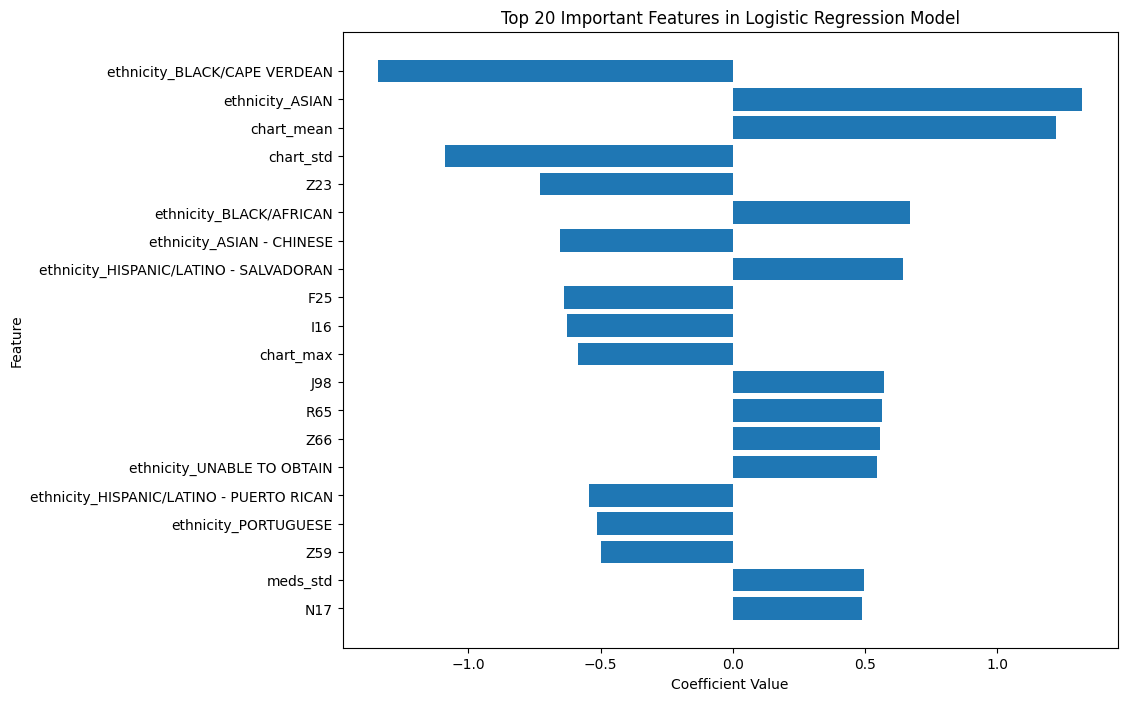

In [19]:
# Plot the feature importance
plot_feature_importance_from_log_model(log_reg_model, X_train, categorical_cols, numerical_cols, save_path)

# Oversampling

In [20]:
# Logistic Regression
log_reg_model = create_model_pipeline(LogisticRegression(max_iter=10000, random_state=42), use_oversampling=True)

# Save the fully trained model (not the one used in cross-validation)
model_name_full = generate_model_name(log_reg_model)

# Define save_path
save_path = f'./saved_models/traditional_models/{model_name_full}/{df_selector.value}/trained_on_{percentage}_subset/'

In [21]:
cv_results_lr, auc_roc_lr, auprc_lr = evaluate_model(log_reg_model, X_train, y_train, scoring, beta=2, save_path=save_path)
print("Logistic Regression:", cv_results_lr)
print(f"Cross-validated AUC-ROC: {auc_roc_lr:.2f}")
print(f"Cross-validated AUPRC: {auprc_lr:.2f}")

Cross-validated Results for LogisticRegression_with_oversampling:
Optimal Threshold: 1.00
Accuracy: 0.85
Precision: 0.28
Recall: 0.55
F1-score: 0.37
Cross-validated AUC-ROC: 0.78
Cross-validated AUPRC: 0.28
Saved confusion matrix plot to ./saved_models/traditional_models/LogisticRegression_with_oversampling/Summarized Dynamic and all Static Features/trained_on_25%_subset/confusion_matrix_cv.png
Saved cross-validated performance metrics to ./saved_models/traditional_models/LogisticRegression_with_oversampling/Summarized Dynamic and all Static Features/trained_on_25%_subset/cross_validated_performance_metrics.json
Logistic Regression: {'accuracy': 0.8453025895042702, 'precision': 0.28069589586854005, 'recall': 0.5544906378927326, 'f1': 0.3723817564304166}
Cross-validated AUC-ROC: 0.78
Cross-validated AUPRC: 0.28


C:\Users\soere\AppData\Local\Temp\ipykernel_15940\3811502246.py:12: RuntimeWarning: invalid value encountered in divide
  f_beta_scores = (1 + beta**2) * (precision * recall) / ((beta**2 * precision) + recall)


Train on Whole Data and Save Model

In [22]:
# Fit the model on the entire training set after cross-validation
log_reg_model.fit(X_train, y_train)

# Evaluate the fully trained model on the test set and print metrics
auc_roc_full, auprc_full = evaluate_full_model(log_reg_model, X_test, y_test, beta=2, save_path=save_path)

dump(log_reg_model, save_path + f"{model_name_full}.joblib")


Classification Report for Model Trained on Full Dataset:
              precision    recall  f1-score   support

           0       0.96      0.83      0.89      3273
           1       0.25      0.63      0.36       296

    accuracy                           0.81      3569
   macro avg       0.61      0.73      0.62      3569
weighted avg       0.90      0.81      0.85      3569

Optimal Threshold: 0.32
AUC-ROC (Full Model): 0.79
AUPRC (Full Model): 0.34
Saved confusion matrix plot to ./saved_models/traditional_models/LogisticRegression_with_oversampling/Summarized Dynamic and all Static Features/trained_on_25%_subset/conf_matrix_no_cross_validation.png
Saved classification report to ./saved_models/traditional_models/LogisticRegression_with_oversampling/Summarized Dynamic and all Static Features/trained_on_25%_subset/performance_metrics_no_cv.json


['./saved_models/traditional_models/LogisticRegression_with_oversampling/Summarized Dynamic and all Static Features/trained_on_25%_subset/LogisticRegression_with_oversampling.joblib']

Feature Importance

Feature importance plot saved to ./saved_models/traditional_models/LogisticRegression_with_oversampling/Summarized Dynamic and all Static Features/trained_on_25%_subset\top_20_feature_importances.png
Feature importance table saved to ./saved_models/traditional_models/LogisticRegression_with_oversampling/Summarized Dynamic and all Static Features/trained_on_25%_subset\feature_importances.csv


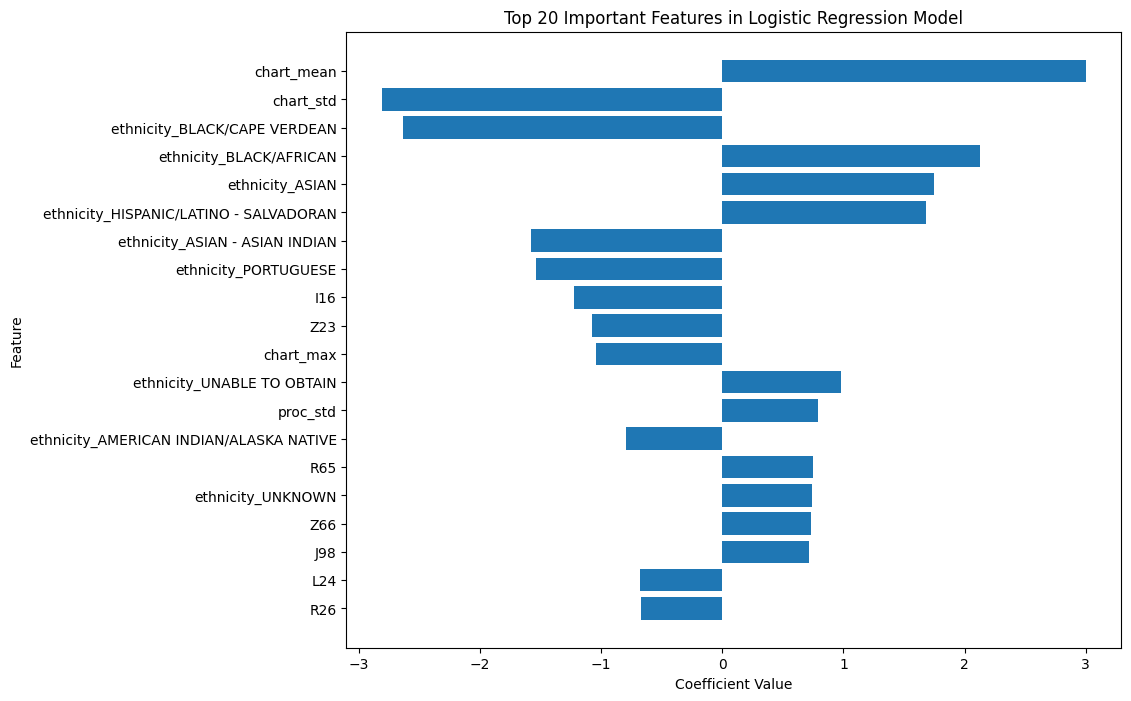

In [23]:
# Plot the feature importance
plot_feature_importance_from_log_model(log_reg_model, X_train, categorical_cols, numerical_cols, save_path)

# Random Forest

No oversampling

In [24]:
"""
# Random Forest
rf_model = create_model_pipeline(RandomForestClassifier(random_state=42), use_oversampling=False)

# Save the fully trained model (not the one used in cross-validation)
model_name_full = generate_model_name(rf_model)

# Define save_path
save_path = f'./saved_models/traditional_models/{model_name_full}/{df_selector.value}/trained_on_{percentage}_subset/'
"""

"\n# Random Forest\nrf_model = create_model_pipeline(RandomForestClassifier(random_state=42), use_oversampling=False)\n\n# Save the fully trained model (not the one used in cross-validation)\nmodel_name_full = generate_model_name(rf_model)\n\n# Define save_path\nsave_path = f'./saved_models/traditional_models/{model_name_full}/{df_selector.value}/trained_on_{percentage}_subset/'\n"

In [25]:
"""
cv_results_rf, auc_roc_rf, auprc_rf = evaluate_model(rf_model, X_train, y_train, scoring, beta=2, save_path=save_path)
print("Random Forest with Oversampling:", cv_results_rf)
print(f"Cross-validated AUC-ROC: {auc_roc_rf:.2f}")
print(f"Cross-validated AUPRC: {auprc_rf:.2f}")
"""

'\ncv_results_rf, auc_roc_rf, auprc_rf = evaluate_model(rf_model, X_train, y_train, scoring, beta=2, save_path=save_path)\nprint("Random Forest with Oversampling:", cv_results_rf)\nprint(f"Cross-validated AUC-ROC: {auc_roc_rf:.2f}")\nprint(f"Cross-validated AUPRC: {auprc_rf:.2f}")\n'

Train on Whole Data and Save Model

In [26]:
"""
# Fit the model on the entire training set after cross-validation
rf_model.fit(X_train, y_train)

# Evaluate the fully trained model on the test set and print metrics
auc_roc_full, auprc_full = evaluate_full_model(rf_model, X_test, y_test, beta=2, save_path=save_path)

dump(rf_model, save_path + f"{model_name_full}.joblib")
"""

'\n# Fit the model on the entire training set after cross-validation\nrf_model.fit(X_train, y_train)\n\n# Evaluate the fully trained model on the test set and print metrics\nauc_roc_full, auprc_full = evaluate_full_model(rf_model, X_test, y_test, beta=2, save_path=save_path)\n\ndump(rf_model, save_path + f"{model_name_full}.joblib")\n'

Feature Importance

In [27]:
#plot_feature_importance_from_tree_model(rf_model, X_train, categorical_cols, numerical_cols, save_path)

# Oversampling

In [28]:
# Random Forest
rf_model = create_model_pipeline(RandomForestClassifier(
        max_depth=30,
        min_samples_leaf=2,
        min_samples_split=2,
        n_estimators=300,
        random_state=42
    ), use_oversampling=True)

# Save the fully trained model (not the one used in cross-validation)
model_name_full = generate_model_name(rf_model)

# Define save_path
save_path = f'./saved_models/traditional_models/{model_name_full}/{df_selector.value}/trained_on_{percentage}_subset/'

In [29]:
cv_results_rf, auc_roc_rf, auprc_rf = evaluate_model(rf_model, X_train, y_train, scoring, beta=2, save_path=save_path)
print("Random Forest with Oversampling:", cv_results_rf)
print(f"Cross-validated AUC-ROC: {auc_roc_rf:.2f}")
print(f"Cross-validated AUPRC: {auprc_rf:.2f}")

Cross-validated Results for RandomForestClassifier_with_oversampling:
Optimal Threshold: 0.28
Accuracy: 0.92
Precision: 0.60
Recall: 0.27
F1-score: 0.38
Cross-validated AUC-ROC: 0.90
Cross-validated AUPRC: 0.47
Saved confusion matrix plot to ./saved_models/traditional_models/RandomForestClassifier_with_oversampling/Summarized Dynamic and all Static Features/trained_on_25%_subset/confusion_matrix_cv.png
Saved cross-validated performance metrics to ./saved_models/traditional_models/RandomForestClassifier_with_oversampling/Summarized Dynamic and all Static Features/trained_on_25%_subset/cross_validated_performance_metrics.json
Random Forest with Oversampling: {'accuracy': 0.9246935530969143, 'precision': 0.5983259361897133, 'recall': 0.27434676822172854, 'f1': 0.3758392542992476}
Cross-validated AUC-ROC: 0.90
Cross-validated AUPRC: 0.47


Train on Whole Data and Save Model

In [30]:
# Fit the model on the entire training set after cross-validation
rf_model.fit(X_train, y_train)

# Evaluate the fully trained model on the test set and print metrics
auc_roc_full, auprc_full = evaluate_full_model(rf_model, X_test, y_test, beta=2, save_path=save_path)

dump(rf_model, save_path + f"{model_name_full}.joblib")


Classification Report for Model Trained on Full Dataset:
              precision    recall  f1-score   support

           0       0.98      0.83      0.90      3273
           1       0.30      0.79      0.44       296

    accuracy                           0.83      3569
   macro avg       0.64      0.81      0.67      3569
weighted avg       0.92      0.83      0.86      3569

Optimal Threshold: 0.27
AUC-ROC (Full Model): 0.89
AUPRC (Full Model): 0.51
Saved confusion matrix plot to ./saved_models/traditional_models/RandomForestClassifier_with_oversampling/Summarized Dynamic and all Static Features/trained_on_25%_subset/conf_matrix_no_cross_validation.png
Saved classification report to ./saved_models/traditional_models/RandomForestClassifier_with_oversampling/Summarized Dynamic and all Static Features/trained_on_25%_subset/performance_metrics_no_cv.json


['./saved_models/traditional_models/RandomForestClassifier_with_oversampling/Summarized Dynamic and all Static Features/trained_on_25%_subset/RandomForestClassifier_with_oversampling.joblib']

Feature Importance

Feature importance plot saved to ./saved_models/traditional_models/RandomForestClassifier_with_oversampling/Summarized Dynamic and all Static Features/trained_on_25%_subset\top_20_feature_importances.png
Feature importance table saved to ./saved_models/traditional_models/RandomForestClassifier_with_oversampling/Summarized Dynamic and all Static Features/trained_on_25%_subset\feature_importances_.csv


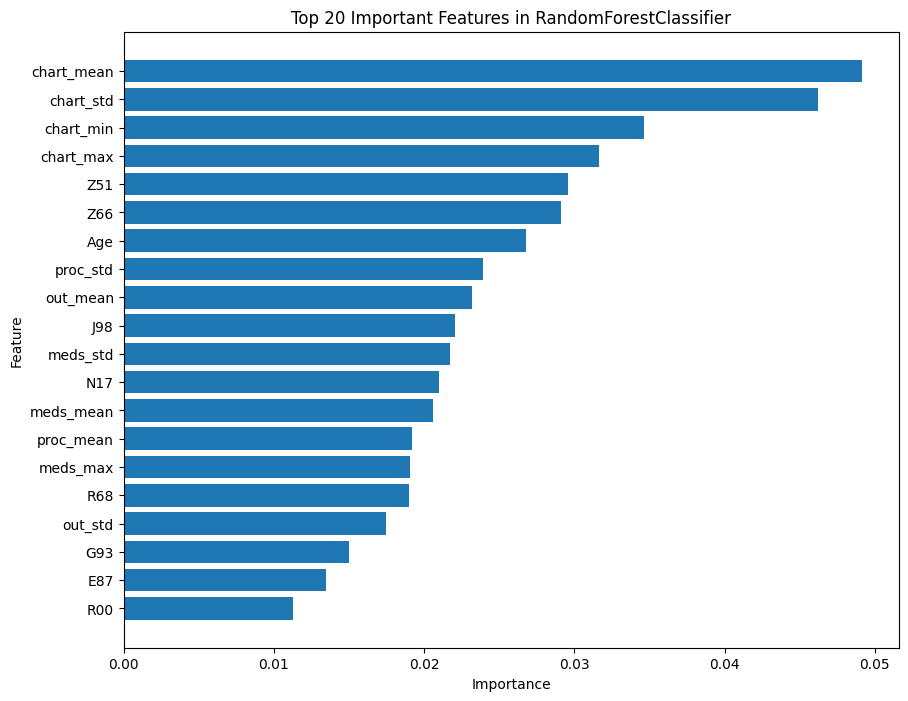

In [31]:
# Plot the feature importances
plot_feature_importance_from_tree_model(rf_model, X_train, categorical_cols, numerical_cols, save_path)

# Gradient Boosting

No Oversampling

In [32]:
"""
# Gradient Boosting
gb_model = create_model_pipeline(GradientBoostingClassifier(random_state=42), use_oversampling=False)

# Save the fully trained model (not the one used in cross-validation)
model_name_full = generate_model_name(gb_model)

# Define save_path
save_path = f'./saved_models/traditional_models/{model_name_full}/{df_selector.value}/trained_on_{percentage}_subset/'
"""

"\n# Gradient Boosting\ngb_model = create_model_pipeline(GradientBoostingClassifier(random_state=42), use_oversampling=False)\n\n# Save the fully trained model (not the one used in cross-validation)\nmodel_name_full = generate_model_name(gb_model)\n\n# Define save_path\nsave_path = f'./saved_models/traditional_models/{model_name_full}/{df_selector.value}/trained_on_{percentage}_subset/'\n"

In [33]:
"""
cv_results_gb, auc_roc_gb, auprc_gb = evaluate_model(gb_model, X_train, y_train, scoring, beta=2, save_path=save_path)
print("Gradient Boosting:", cv_results_gb)
print(f"Cross-validated AUC-ROC: {auc_roc_gb:.2f}")
print(f"Cross-validated AUPRC: {auprc_gb:.2f}")
"""

'\ncv_results_gb, auc_roc_gb, auprc_gb = evaluate_model(gb_model, X_train, y_train, scoring, beta=2, save_path=save_path)\nprint("Gradient Boosting:", cv_results_gb)\nprint(f"Cross-validated AUC-ROC: {auc_roc_gb:.2f}")\nprint(f"Cross-validated AUPRC: {auprc_gb:.2f}")\n'

Train on Whole Data and Save Model

In [34]:
"""
# Fit the model on the entire training set after cross-validation
gb_model.fit(X_train, y_train)

# Evaluate the fully trained model on the test set and print metrics
auc_roc_full, auprc_full = evaluate_full_model(gb_model, X_test, y_test, beta=2, save_path=save_path)

# Save the fully trained model (not the one used in cross-validation)
dump(gb_model, save_path + f"{model_name_full}.joblib")
"""

'\n# Fit the model on the entire training set after cross-validation\ngb_model.fit(X_train, y_train)\n\n# Evaluate the fully trained model on the test set and print metrics\nauc_roc_full, auprc_full = evaluate_full_model(gb_model, X_test, y_test, beta=2, save_path=save_path)\n\n# Save the fully trained model (not the one used in cross-validation)\ndump(gb_model, save_path + f"{model_name_full}.joblib")\n'

Feature Importance

In [35]:
#plot_feature_importance_from_tree_model(gb_model, X_train, categorical_cols, numerical_cols, save_path)

Oversampling

In [36]:
# Gradient Boosting
gb_model = create_model_pipeline(GradientBoostingClassifier(
        learning_rate=0.2,
        max_depth=5,
        min_samples_leaf=1,
        min_samples_split=2,
        n_estimators=200,
        random_state=42
    ), use_oversampling=True)

# Save the fully trained model (not the one used in cross-validation)
model_name_full = generate_model_name(gb_model)

# Define save_path
save_path = f'./saved_models/traditional_models/{model_name_full}/{df_selector.value}/trained_on_{percentage}_subset/'

In [37]:
cv_results_gb, auc_roc_gb, auprc_gb = evaluate_model(gb_model, X_train, y_train, scoring, beta=2, save_path=save_path)
print("Gradient Boosting:", cv_results_gb)
print(f"Cross-validated AUC-ROC: {auc_roc_gb:.2f}")
print(f"Cross-validated AUPRC: {auprc_gb:.2f}")

KeyboardInterrupt: 

Train on whole Data and Save Model

In [38]:
# Fit the model on the entire training set after cross-validation
gb_model.fit(X_train, y_train)

# Evaluate the fully trained model on the test set and print metrics
auc_roc_full, auprc_full = evaluate_full_model(gb_model, X_test, y_test, beta=2, save_path=save_path)

# Save the fully trained model (not the one used in cross-validation)
dump(gb_model, save_path + f"{model_name_full}.joblib")


Classification Report for Model Trained on Full Dataset:
              precision    recall  f1-score   support

           0       0.98      0.85      0.91      6546
           1       0.32      0.78      0.45       591

    accuracy                           0.84      7137
   macro avg       0.65      0.81      0.68      7137
weighted avg       0.92      0.84      0.87      7137

Optimal Threshold: 0.30
AUC-ROC (Full Model): 0.89
AUPRC (Full Model): 0.49
Saved confusion matrix plot to ./saved_models/traditional_models/GradientBoostingClassifier_with_oversampling/Summarized Dynamic and all Static Features/trained_on_50%_subset/conf_matrix_no_cross_validation.png
Saved classification report to ./saved_models/traditional_models/GradientBoostingClassifier_with_oversampling/Summarized Dynamic and all Static Features/trained_on_50%_subset/performance_metrics_no_cv.json


['./saved_models/traditional_models/GradientBoostingClassifier_with_oversampling/Summarized Dynamic and all Static Features/trained_on_50%_subset/GradientBoostingClassifier_with_oversampling.joblib']

Feature Importance

Feature importance plot saved to ./saved_models/traditional_models/GradientBoostingClassifier_with_oversampling/Summarized Dynamic and all Static Features/trained_on_50%_subset\top_20_feature_importances.png
Feature importance table saved to ./saved_models/traditional_models/GradientBoostingClassifier_with_oversampling/Summarized Dynamic and all Static Features/trained_on_50%_subset\feature_importances_.csv


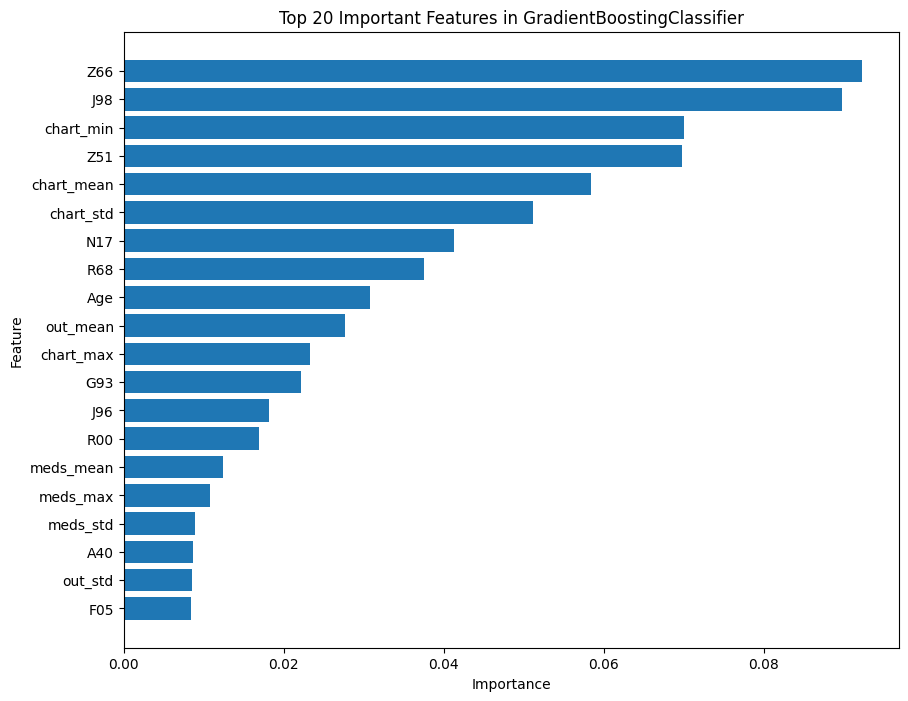

In [39]:
# Plot the Feature Importance
plot_feature_importance_from_tree_model(gb_model, X_train, categorical_cols, numerical_cols, save_path)

# MLP Classifier

No Oversampling

In [40]:
"""
# Define the MLP models
mlp_model = create_model_pipeline(MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000, solver='adam', random_state=42), use_oversampling=False)

# Generate model name
model_name_full = generate_model_name(mlp_model)

# Define save_path
save_path = f'./saved_models/traditional_models/{model_name_full}/{df_selector.value}/trained_on_{percentage}_subset/'
"""

"\n# The parameters can be adjusted based on your dataset size and feature complexity\nmlp_model = create_model_pipeline(MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000, solver='adam', random_state=42), use_oversampling=False)\n\n# Generate model name\nmodel_name_full = generate_model_name(mlp_model)\n\n# Define save_path\nsave_path = f'./saved_models/traditional_models/{model_name_full}/{df_selector.value}/trained_on_{percentage}_subset/'\n"

In [41]:
# Evaluate the MLP model using the defined cross-validation framework and scoring metrics
#cv_results_mlp, auc_roc_mlp, auprc_mlp = evaluate_model(mlp_model, X_train, y_train, scoring, beta=2, save_path=save_path)
"""
# Print the results for the MLP model
print("MLP Classifier:")
print("Cross-validation scores:", cv_results_mlp)
print(f"Cross-validated AUC-ROC: {auc_roc_mlp:.2f}")
print(f"Cross-validated AUPRC: {auprc_mlp:.2f}")
"""

'\n# Print the results for the MLP model\nprint("MLP Classifier:")\nprint("Cross-validation scores:", cv_results_mlp)\nprint(f"Cross-validated AUC-ROC: {auc_roc_mlp:.2f}")\nprint(f"Cross-validated AUPRC: {auprc_mlp:.2f}")\n'

Train on Whole Data and Save Model

In [42]:
"""
# Fit the model on the entire training set after cross-validation
mlp_model.fit(X_train, y_train)

# Evaluate the fully trained model on the test set and print metrics
auc_roc_full, auprc_full = evaluate_full_model(mlp_model, X_test, y_test, beta=2, save_path=save_path)

# Save the fully trained model (not the one used in cross-validation)
dump(mlp_model, save_path + f"{model_name_full}.joblib")
"""

'\n# Fit the model on the entire training set after cross-validation\nmlp_model.fit(X_train, y_train)\n\n# Evaluate the fully trained model on the test set and print metrics\nauc_roc_full, auprc_full = evaluate_full_model(mlp_model, X_test, y_test, beta=2, save_path=save_path)\n\n# Save the fully trained model (not the one used in cross-validation)\ndump(mlp_model, save_path + f"{model_name_full}.joblib")\n'

In [43]:
"""
# Call FEature importances Function
importances = perturbation_feature_importance(mlp_model, X_train, y_train)
feature_names = X_train.columns  # Assuming X_train is a DataFrame
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})
"""

"\n# Call the function\nimportances = perturbation_feature_importance(mlp_model, X_train, y_train)\nfeature_names = X_train.columns  # Assuming X_train is a DataFrame\nfeature_importance_df = pd.DataFrame({\n    'Feature': feature_names,\n    'Importance': importances\n})\n"

In [44]:
"""
feature_importance_sorted = feature_importance_df.sort_values(by='Importance', ascending=False)
feature_importance_sorted.to_csv(f'./saved_models/traditional_models/trained_on_{percentage}_subset/{df_selector.value}/{model_name_full}/pertubation_importances.csv')
"""

"\nfeature_importance_sorted = feature_importance_df.sort_values(by='Importance', ascending=False)\nfeature_importance_sorted.to_csv(f'./saved_models/traditional_models/trained_on_{percentage}_subset/{df_selector.value}/{model_name_full}/pertubation_importances.csv')\n"

In [45]:
# Call the function with your sorted DataFrame
#plot_perturbation_importances(feature_importance_sorted, save_path=f'./saved_models/traditional_models/trained_on_{percentage}_subset/{df_selector.value}/{model_name_full}/top_20_pertubation_importances.png')

Oversampling

In [17]:
# Call the Feature Importances Function
mlp_model = create_model_pipeline(MLPClassifier(activation="relu", alpha=0.01, hidden_layer_sizes=(50,), max_iter=1000, learning_rate_init=0.01, solver='adam', random_state=42), use_oversampling=True)

# Generate model name
model_name_full = generate_model_name(mlp_model)

# Define save_path
save_path = f'./saved_models/traditional_models/{model_name_full}/{df_selector.value}/trained_on_{percentage}_subset/'

In [18]:
# Evaluate the MLP model using the defined cross-validation framework and scoring metrics
cv_results_mlp, auc_roc_mlp, auprc_mlp = evaluate_model(mlp_model, X_train, y_train, scoring, beta=2, save_path=save_path)

# Print the results for the MLP model
print("MLP Classifier:")
print("Cross-validation scores:", cv_results_mlp)
print(f"Cross-validated AUC-ROC: {auc_roc_mlp:.2f}")
print(f"Cross-validated AUPRC: {auprc_mlp:.2f}")

Cross-validated Results for MLPClassifier_with_oversampling:
Optimal Threshold: 1.00
Accuracy: 0.90
Precision: 0.40
Recall: 0.34
F1-score: 0.36
Cross-validated AUC-ROC: 0.82
Cross-validated AUPRC: 0.31
Saved confusion matrix plot to ./saved_models/traditional_models/MLPClassifier_with_oversampling/ICD Codes/trained_on_25%_subset/confusion_matrix_cv.png
Saved cross-validated performance metrics to ./saved_models/traditional_models/MLPClassifier_with_oversampling/ICD Codes/trained_on_25%_subset/cross_validated_performance_metrics.json
MLP Classifier:
Cross-validation scores: {'accuracy': 0.9024745754157518, 'precision': 0.3965162786426045, 'recall': 0.3381571987728763, 'f1': 0.36477674543198735}
Cross-validated AUC-ROC: 0.82
Cross-validated AUPRC: 0.31


C:\Users\soere\AppData\Local\Temp\ipykernel_32764\3811502246.py:12: RuntimeWarning: invalid value encountered in divide
  f_beta_scores = (1 + beta**2) * (precision * recall) / ((beta**2 * precision) + recall)


Train on whole Data

In [19]:
# Fit the model on the entire training set after cross-validation
mlp_model.fit(X_train, y_train)

# Evaluate the fully trained model on the test set and print metrics
auc_roc_full, auprc_full = evaluate_full_model(mlp_model, X_test, y_test, beta=2, save_path=save_path)

# Save the fully trained model (not the one used in cross-validation)
dump(mlp_model, save_path + f"{model_name_full}.joblib")


Classification Report for Model Trained on Full Dataset:
              precision    recall  f1-score   support

           0       0.92      1.00      0.96      3273
           1       0.00      0.00      0.00       296

    accuracy                           0.92      3569
   macro avg       0.46      0.50      0.48      3569
weighted avg       0.84      0.92      0.88      3569

Optimal Threshold: 1.00
AUC-ROC (Full Model): 0.82
AUPRC (Full Model): 0.29
Saved confusion matrix plot to ./saved_models/traditional_models/MLPClassifier_with_oversampling/ICD Codes/trained_on_25%_subset/conf_matrix_no_cross_validation.png
Saved classification report to ./saved_models/traditional_models/MLPClassifier_with_oversampling/ICD Codes/trained_on_25%_subset/performance_metrics_no_cv.json


C:\Users\soere\AppData\Local\Temp\ipykernel_32764\3375389213.py:6: RuntimeWarning: invalid value encountered in divide
  f_beta_scores = (1 + beta**2) * (precision * recall) / ((beta**2 * precision) + recall)


['./saved_models/traditional_models/MLPClassifier_with_oversampling/ICD Codes/trained_on_25%_subset/MLPClassifier_with_oversampling.joblib']

Feature importance plot saved to ./saved_models/traditional_models/MLPClassifier_with_oversampling/ICD Codes/trained_on_25%_subset/top_20_pertubation_importances.png


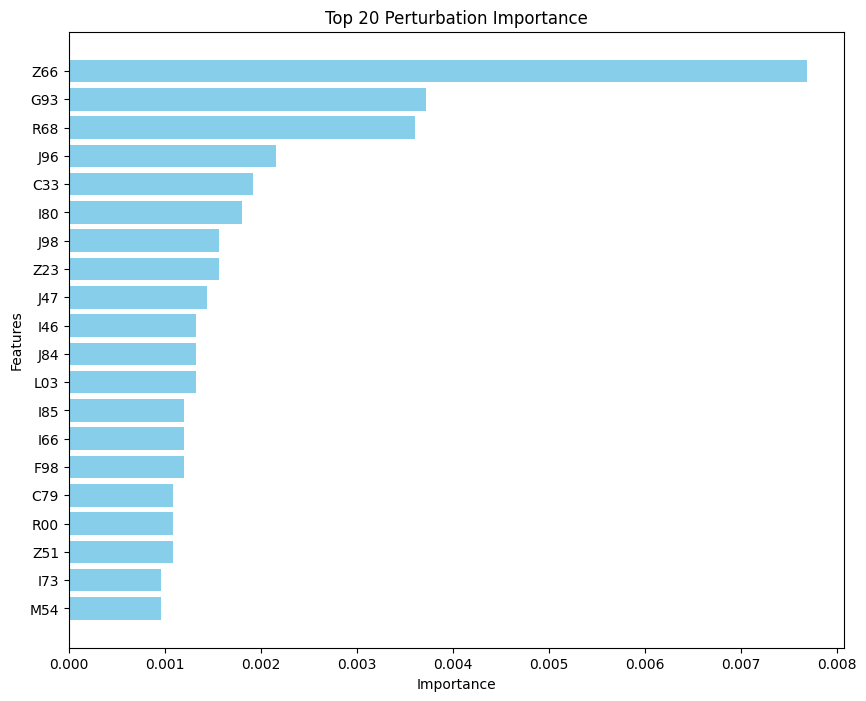

In [20]:
# Compute Paertubation importances
importances = perturbation_feature_importance(mlp_model, X_train, y_train)
feature_names = X_train.columns  
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

feature_importance_sorted = feature_importance_df.sort_values(by='Importance', ascending=False)
feature_importance_sorted.to_csv(f'./saved_models/traditional_models//{model_name_full}/{df_selector.value}/trained_on_{percentage}_subset/pertubation_importances.csv')

# Call the function with the sorted DataFrame
plot_perturbation_importances(feature_importance_sorted, save_path=f'./saved_models/traditional_models/{model_name_full}/{df_selector.value}/trained_on_{percentage}_subset/top_20_pertubation_importances.png')